## Demo for Project 2

### Initialize environments and build models

In [1]:
import os, sys, numpy as np
sys.path.insert(0, 'python')
import hmm, pickle

# read data and initialize the model
lblnames = os.path.join('data', 'clsp.lblnames')
scr = os.path.join('data', 'clsp.trnscr')
pts = os.path.join('data', 'clsp.endpts')
lbl = os.path.join('data', 'clsp.trnlbls')

trainer = hmm.Trainer()
trainer.read_fenones(lblnames)
trainer.pick_fenonic_baseforms(scr, pts, lbl)
trainer.read_training_data(scr, lbl)

trainer.build_baseforms()
trainer.init_training_trellis()
trainer.init_modelpool()
trainer.update_trellis()

[init_training_trellis] 798/798 done


## Primary System
### problem 1
A plot of the training data log-likelihood as a function of the number of iterations.

In [2]:
# train for 256 epochs
alp_list = []
trainer.forward()
alp_list.append(trainer.getalp())

for epoch in range(256):
    sys.stdout.write('\r[training] {:03d} / 256'.format(epoch + 1))
    sys.stdout.flush()
    trainer.backward()
    trainer.update_modelpool()
    trainer.update_trellis()
    trainer.forward()
    alp_list.append(trainer.getalp())
print ' done'
    
with open(os.path.join('results', 'alp.p'), 'wb') as f:
    pickle.dump(alp_list, f)

[training] 256 / 256 done


In [3]:
trainer.save_model(os.path.join('modelpool', 'model_256.p'))

Plotting the mean ALP over the training_dataset

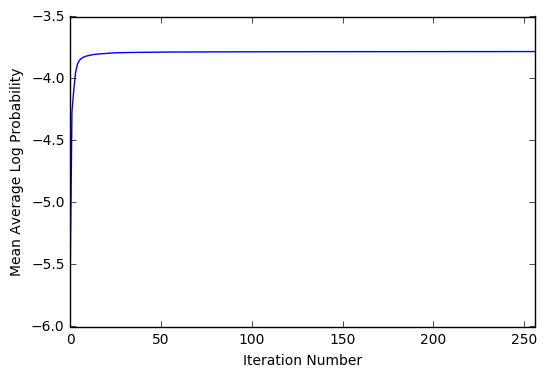

In [5]:
import matplotlib.pyplot as plt

# load the alp_list
with open(os.path.join('results', 'alp.p'), 'rb') as f:
    alp_list = pickle.load(f)

malg_x = [x for x in range(257)]
malg_y = []
for i in range(len(alp_list)):
    malg_y.append(np.mean(alp_list[i]))
plot = plt.plot(malg_x, malg_y, 'b-')
plt.ylabel('Mean Average Log Probability')
plt.xlabel('Iteration Number')
plt.axis([0, 256, -6, -3.5])
plt.savefig(os.path.join('results', 'p1.pdf'))
plt.show()

For each utterance in the test data, the identity of the most likely word and a confidence.

In [7]:
# read dev data
devwav = os.path.join('data', 'clsp.devwav')
devlbl = os.path.join('data', 'clsp.devlbls')
devwav = open(devwav).readlines()[1:]
devlbl = open(devlbl).readlines()[1:]
dev_list = []
for i in range(len(devwav)):
    wavline = devwav[i][:-1]
    lblline = devlbl[i][:-1]
    lblline = lblline.split(' ')[:-1]
    dev_list.append([wavline, lblline])
    
infer_list = []
for i in range(len(dev_list)):
    sys.stdout.write('\r[testing] {:03d} / {}'.format(
            i + 1, len(dev_list)))
    sys.stdout.flush()
    word_list, score_list = trainer.infer(data=dev_list[i][1])
    inferred = word_list[np.argmax(score_list)]
    confidence = np.max(score_list)
    infer_list.append([dev_list[i][0], inferred, confidence])
print ' done'

with open('results/dev.p', 'wb') as f:
    pickle.dump(infer_list, f)

[testing] 393 / 393 done


## Contrastive System
### Training + Validation

In [1]:
import os, sys, numpy as np, random as rd
sys.path.insert(0, 'python')
import hmm, pickle

rd.seed(1)

# read data and initialize the model
lblnames = os.path.join('data', 'clsp.lblnames')
scr = os.path.join('data', 'clsp.trnscr')
pts = os.path.join('data', 'clsp.endpts')
lbl = os.path.join('data', 'clsp.trnlbls')

trainer = hmm.Trainer()
trainer.read_fenones(lblnames)
trainer.pick_fenonic_baseforms(scr, pts, lbl)
trainer.read_training_data(scr, lbl)

# split the training data into training data and validation data
training_data = trainer.training_data
training_map = {}
for i in range(len(training_data)):
    word, data = training_data[i]
    if not word in training_map:
        training_map[word] = []
    training_map[word].append(i)
train_new, val_new = [], []
for word in training_map:
    val_ids = rd.sample(training_map[word], k=3)
    train_ids = list(set(training_map[word])-set(val_ids))
    for idx in val_ids:
        val_new.append(training_data[idx])
    for idx in train_ids:
        train_new.append(training_data[idx])
trainer.training_data = train_new

trainer.build_baseforms()
trainer.init_training_trellis()
trainer.init_modelpool()
trainer.update_trellis()

[init_training_trellis] 654/654 done


train + validate

In [2]:
trainer.forward()
alp = trainer.getalp()
acc = 0.0
for i in range(len(val_new)):
    sys.stdout.write('\r[validating] {:03d} / {:03d}'.format(i+1, len(val_new)))
    sys.stdout.flush()
    word_list, score_list = trainer.infer(val_new[i][1])
    inferred = word_list[np.argmax(score_list)]
    if inferred == val_new[i][0]:
        acc += 1
print ' done'
ratio = acc / len(val_new)
print 'malp: {:.3f} @ {:03d} | accuracy: {:.3f}'.format(np.mean(alp), 0, ratio)
for epoch in range(20):
    trainer.backward()
    trainer.update_modelpool()
    trainer.update_trellis()
    trainer.save_model(os.path.join('modelpool', 'model_{}.p'.format(epoch+1)))
    trainer.forward()
    alp = trainer.getalp()
    acc = 0.0
    for i in range(len(val_new)):
        sys.stdout.write('\r[validating] {:03d} / {:03d}'.format(i+1, len(val_new)))
        sys.stdout.flush()
        word_list, score_list = trainer.infer(val_new[i][1])
        inferred = word_list[np.argmax(score_list)]
        if inferred == val_new[i][0]:
            acc += 1
    print ' done'
    ratio = acc / len(val_new)
    print 'malp: {:.3f} @ {:03d} | accuracy: {:.3f}'.format(np.mean(alp), epoch + 1, ratio)

[validating] 144 / 144 done
malp: -5.646 @ 000 | accuracy: 0.590
[validating] 144 / 144 done
malp: -4.265 @ 001 | accuracy: 0.875
[validating] 144 / 144 done
malp: -4.090 @ 002 | accuracy: 0.882
[validating] 144 / 144 done
malp: -3.944 @ 003 | accuracy: 0.882
[validating] 144 / 144 done
malp: -3.882 @ 004 | accuracy: 0.854
[validating] 144 / 144 done
malp: -3.853 @ 005 | accuracy: 0.840
[validating] 144 / 144 done
malp: -3.837 @ 006 | accuracy: 0.833
[validating] 144 / 144 done
malp: -3.827 @ 007 | accuracy: 0.826
[validating] 144 / 144 done
malp: -3.820 @ 008 | accuracy: 0.785
[validating] 144 / 144 done
malp: -3.814 @ 009 | accuracy: 0.778
[validating] 144 / 144 done
malp: -3.810 @ 010 | accuracy: 0.771
[validating] 144 / 144 done
malp: -3.806 @ 011 | accuracy: 0.757
[validating] 144 / 144 done
malp: -3.803 @ 012 | accuracy: 0.743
[validating] 144 / 144 done
malp: -3.801 @ 013 | accuracy: 0.729
[validating] 144 / 144 done
malp: -3.799 @ 014 | accuracy: 0.729
[validating] 144 / 144 do